# Evaluating and comparing methods:

In [1]:
# Import requirement libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import *
import venn

In [2]:
# Read results and the gold standard
cent_B = pd.read_csv('centralities_B.csv')
cent_C = pd.read_csv('centralities_C.csv')
cent_L = pd.read_csv('centralities_L.csv')

nodes_B = pd.read_csv('node_B.csv').drop_duplicates(ignore_index=True)
nodes_C = pd.read_csv('node_C.csv').drop_duplicates(ignore_index=True)
nodes_L = pd.read_csv('node_L.csv').drop_duplicates(ignore_index=True)
print(len(nodes_B))
print(len(nodes_C))
print(len(nodes_L))

nodes_L = pd.concat([nodes_L, pd.DataFrame(np.repeat(0, len(nodes_L)), columns = ['TRUE'])],axis=1)
nodes_B = pd.concat([nodes_B, pd.DataFrame(np.repeat(0, len(nodes_B)), columns = ['TRUE'])],axis=1)
nodes_C = pd.concat([nodes_C, pd.DataFrame(np.repeat(0, len(nodes_C)), columns = ['TRUE'])],axis=1)

driver_true = pd.read_csv('driver_true.csv')
driver_B = pd.concat([driver_true['Breast_cancer'].dropna(), 
                      pd.DataFrame(np.repeat(1, len(driver_true['Breast_cancer'].dropna())), columns=['TRUE'])], axis=1)
driver_B = driver_B.rename(columns={'Breast_cancer':'Name'})
driver_C = pd.concat([driver_true['Colon_cancer'].dropna(), 
                      pd.DataFrame(np.repeat(1, len(driver_true['Colon_cancer'].dropna())), columns=['TRUE'])], axis=1)
driver_C = driver_C.rename(columns={'Colon_cancer':'Name'})
driver_L = pd.concat([driver_true['Lung_cancer'].dropna(), 
                      pd.DataFrame(np.repeat(1, len(driver_true['Lung_cancer'].dropna())), columns=['TRUE'])], axis=1)
driver_L = driver_L.rename(columns={'Lung_cancer':'Name'})
print(driver_B.shape)
print(driver_C.shape)
print(driver_L.shape)

df_B = pd.read_excel("OtherMethods_B.xlsx")
df_C = pd.read_excel("OtherMethods_C.xlsx")
df_L = pd.read_excel("OtherMethods_L.xlsx")
df_C.columns.values[4]

10882
15664
11015
(572, 2)
(572, 2)
(566, 2)


'MeMo'

In [3]:
def evaluate_methods(x, nodes, driver):
    
    TN, FN, TP, FP, F_measure, acc, recall, precision = [], [], [], [], [], [], [], []
    driver_pred = pd.DataFrame()
    l = x.columns.values
    for i in range(0, len(l)):
        x1 = pd.DataFrame(np.repeat(1, len(x.iloc[:,i].dropna())), columns = ['label'])
        y = pd.concat([pd.DataFrame(x.iloc[:,i].dropna().reset_index(drop=True)).rename(columns={x.columns.values[i]:'Name'}),
                       x1.reset_index(drop=True)], axis=1)
        df1 = pd.merge(driver, y, on ='Name', how ='outer')
        df1.fillna(0, inplace=True)
        df2 = pd.merge(df1, nodes, on =['Name','TRUE'], how ='outer')
        df2.fillna(0, inplace=True)  
        yp = pd.merge(df2[df2.label==1], df2[df2.TRUE==1], on =['Name','TRUE','label'], how ='inner')
        driver_pred = pd.concat([driver_pred, yp.Name], axis=1)
        confusionM = confusion_matrix(df2['TRUE'], df2['label'])
        FN = np.append(FN, confusionM[0,1])
        TN = np.append(TN, confusionM[1,1])
        TP = np.append(TP, confusionM[0,0])
        FP = np.append(FP, confusionM[1,0])  
        F_measure = np.append(F_measure, f1_score(df2['TRUE'], df2['label']))
        acc = np.append(acc, accuracy_score(df2['TRUE'], df2['label']))
        recall = np.append(recall, recall_score(df2['TRUE'], df2['label']))
        precision = np.append(precision, precision_score(df2['TRUE'], df2['label'], zero_division=0))
    Criterion1 = pd.DataFrame(x.columns.values, columns=['Method Name'])
    Criterion1['value'] = pd.DataFrame(F_measure)
    Criterion1['Criterion'] = np.repeat('F-measure', len(Criterion1))
    Criterion2 = pd.DataFrame(x.columns.values, columns=['Method Name'])
    Criterion2['value'] = pd.DataFrame(precision)
    Criterion2['Criterion'] = np.repeat('Precision', len(Criterion2))
    Criterion3 = pd.DataFrame(x.columns.values, columns=['Method Name'])
    Criterion3['value'] = pd.DataFrame(recall)
    Criterion3['Criterion'] = np.repeat('Recall', len(Criterion3))
    Criterion4 = pd.DataFrame(x.columns.values, columns=['Method Name'])
    Criterion4['value'] = pd.DataFrame(acc)
    Criterion4['Criterion'] = np.repeat('Accuracy', len(Criterion4))
    Criterion = pd.concat([Criterion2,Criterion1,Criterion3,Criterion4]).round(3)
    CM =  pd.DataFrame(x.columns.values,columns=['Method Name'])
    CM['TN'] = pd.DataFrame(TN)
    CM['TP'] = pd.DataFrame(TP)
    CM['FN'] = pd.DataFrame(FN)
    CM['FP'] = pd.DataFrame(FP)
    
    return(FN, TN, FP, TP,  F_measure, acc, recall, precision, driver_pred, Criterion, CM)

In [4]:
resultE_B = evaluate_methods(df_B, nodes_B, driver_B) 
resultE_C = evaluate_methods(df_C, nodes_C, driver_C)
resultE_L = evaluate_methods(df_L, nodes_L, driver_L)

In [5]:
criterion_B = resultE_B[9]
CM_B = resultE_B[10]
CM_B['Type'] = np.repeat('Breast Cancer Network', len(CM_B))

criterion_C = resultE_C[9]
CM_C = resultE_C[10]
CM_C['Type'] = np.repeat('Colon Cancer Network', len(CM_C))

criterion_L = resultE_L[9]
CM_L = resultE_L[10]
CM_L['Type'] = np.repeat('Lung Cancer Network', len(CM_L))
CM = pd.concat([CM_B,CM_C,CM_L], axis=0)

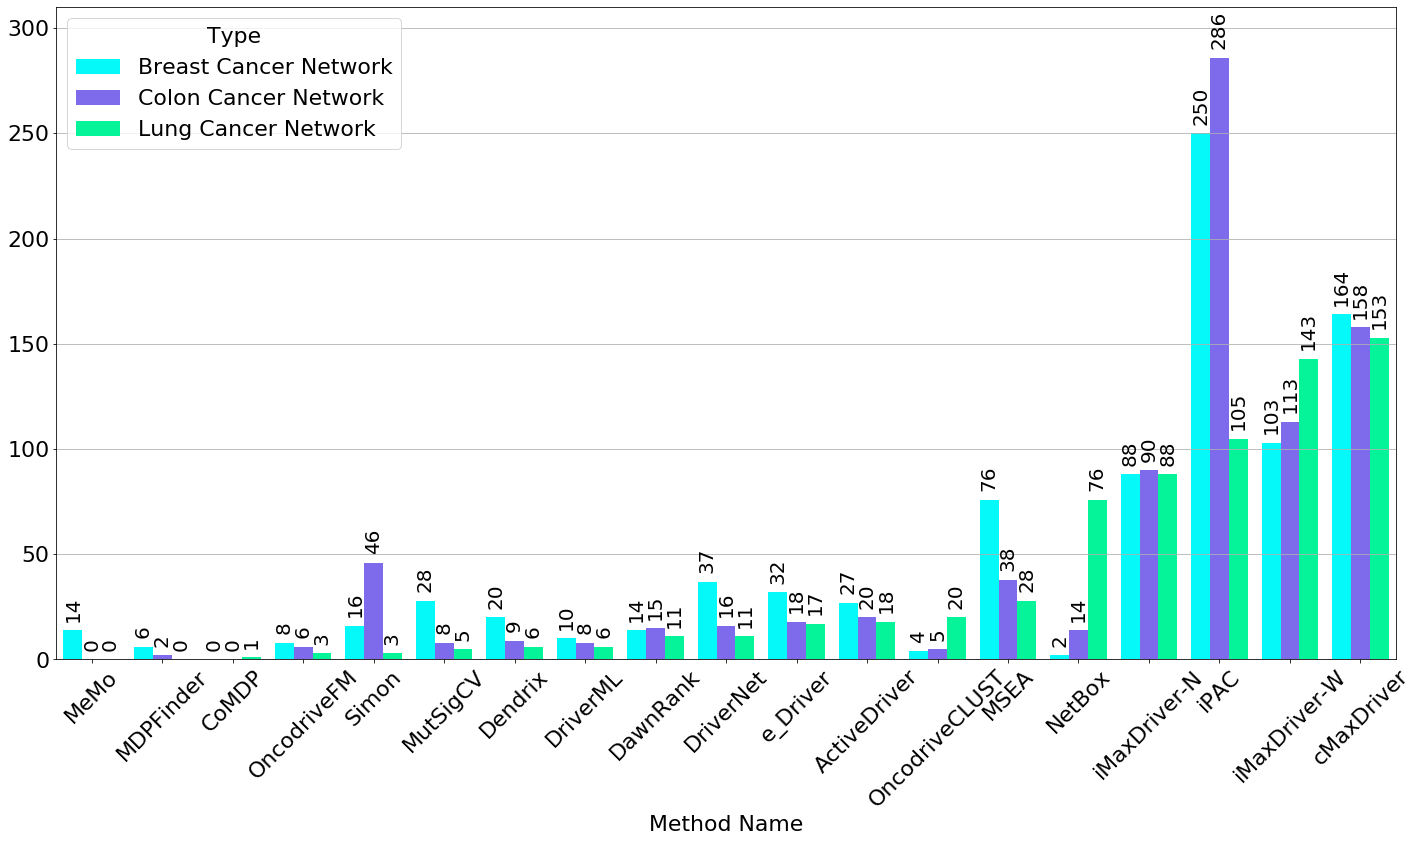

In [14]:
fig, ax = plt.subplots(figsize =(24, 12))
plt.grid(True)

# Create an array with the colors you want to use
colors = ['#00FFFF','#7C68EE','#00FA9A']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
C = sns.barplot(x="Method Name", y="TN", data=CM, hue="Type", 
                 saturation=0.95, order=CM_L.sort_values("TN")["Method Name"])
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2, 4+rect.get_height(),"%.0f"% rect.get_height(), ha='center', 
             va='bottom',rotation=90, fontsize=20)
C.set(ylabel=None)  # remove the ticks
C.set(ylim=(0, 310))
plt.setp(C.get_xticklabels(), rotation=45)
plt.rcParams.update({'font.size': 22})

plt.savefig('CDG.png', Cbox_inches='tight')
plt.show()

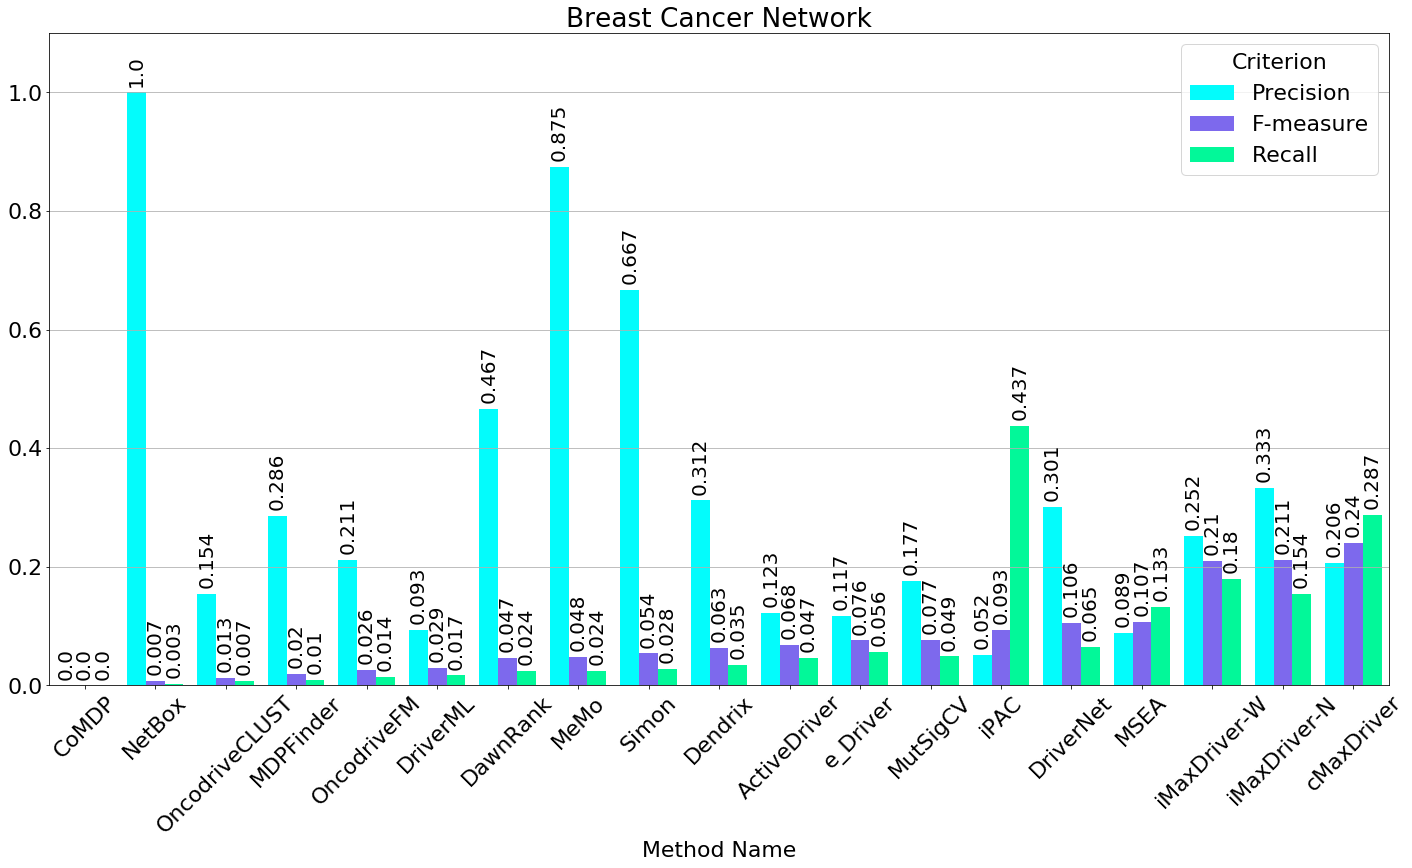

In [15]:
fig, ax = plt.subplots(figsize =(24, 12))
plt.grid(True)

sns.set_palette(sns.color_palette(colors))
C2 = sns.barplot(x="Method Name", y="value", data=criterion_B.iloc[:57,], hue="Criterion", 
                saturation=0.98, order=pd.DataFrame(criterion_B.iloc[19:38,]).sort_values("value")["Method Name"])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width(), 0.01+rect.get_height(),rect.get_height(), ha='right', 
             va='bottom', rotation=90, fontsize=20)
C2.set(ylabel=None) 
C2.set(ylim=(0, 1.1))
plt.setp(C2.get_xticklabels(), rotation=45)
plt.rcParams.update({'font.size': 22})
plt.legend(loc='upper right', title= 'Criterion')
plt.title('Breast Cancer Network')

plt.savefig('B.png', Cbox_inches='tight')
plt.show()

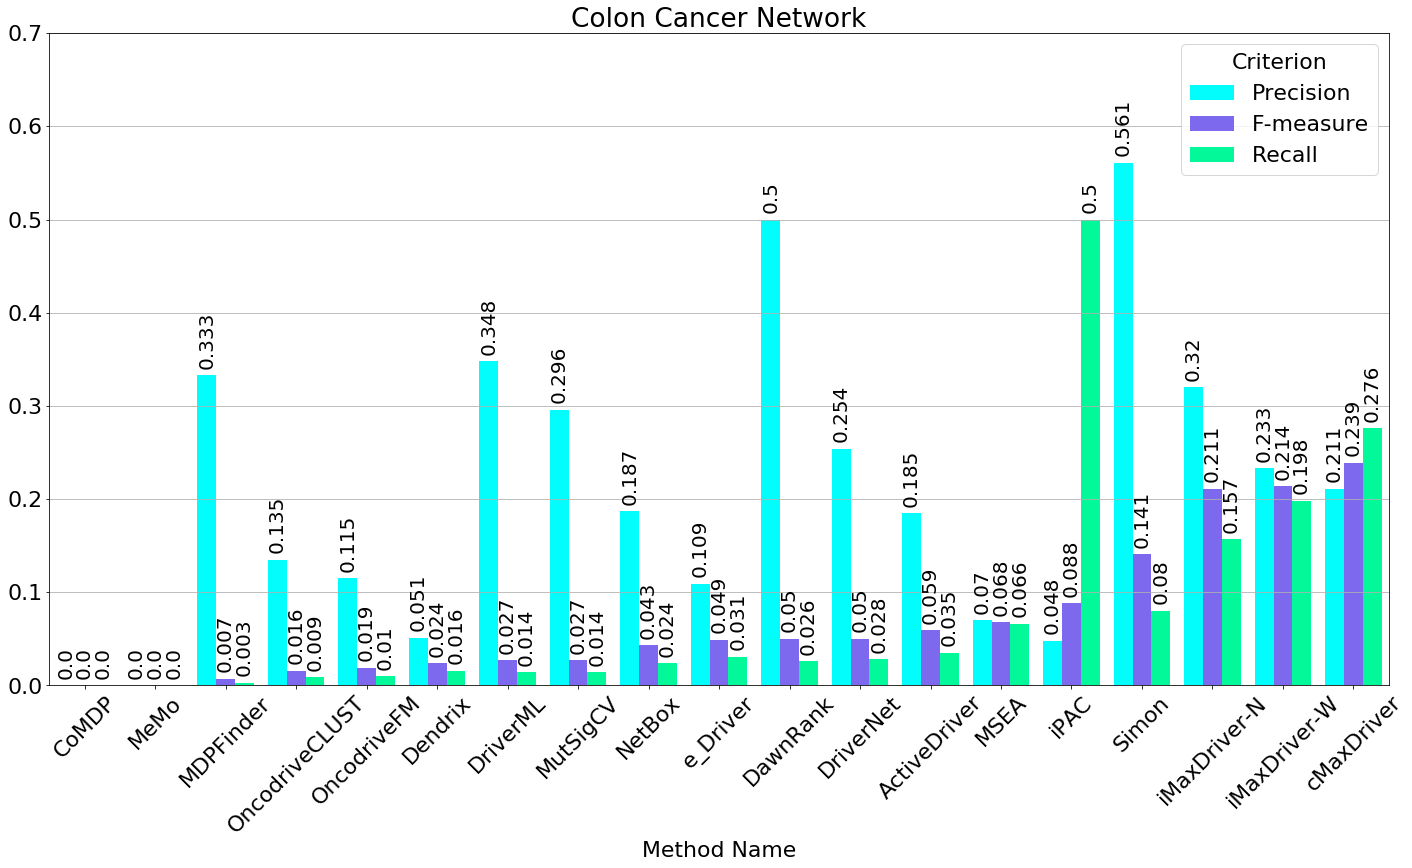

In [16]:
fig, ax = plt.subplots(figsize =(24, 12))
plt.grid(True)

sns.set_palette(sns.color_palette(colors))
Cl = sns.barplot(x="Method Name", y="value", data=criterion_C.iloc[:57,], hue="Criterion", 
                 saturation=0.98, order=pd.DataFrame(criterion_C.iloc[19:38,]).sort_values("value")["Method Name"])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width(), 0.007+rect.get_height(),rect.get_height(), ha='right', 
             va='bottom', rotation=90, fontsize=20)
Cl.set(ylabel=None) 
Cl.set(ylim=(0, 1.1))
plt.setp(Cl.get_xticklabels(), rotation=45)
plt.rcParams.update({'font.size': 22})
plt.legend(loc='upper right', title= 'Criterion')
plt.title('Colon Cancer Network')
Cl.set(ylim=(0, 0.7))

plt.savefig('C.png', Cbox_inches='tight')
plt.show()

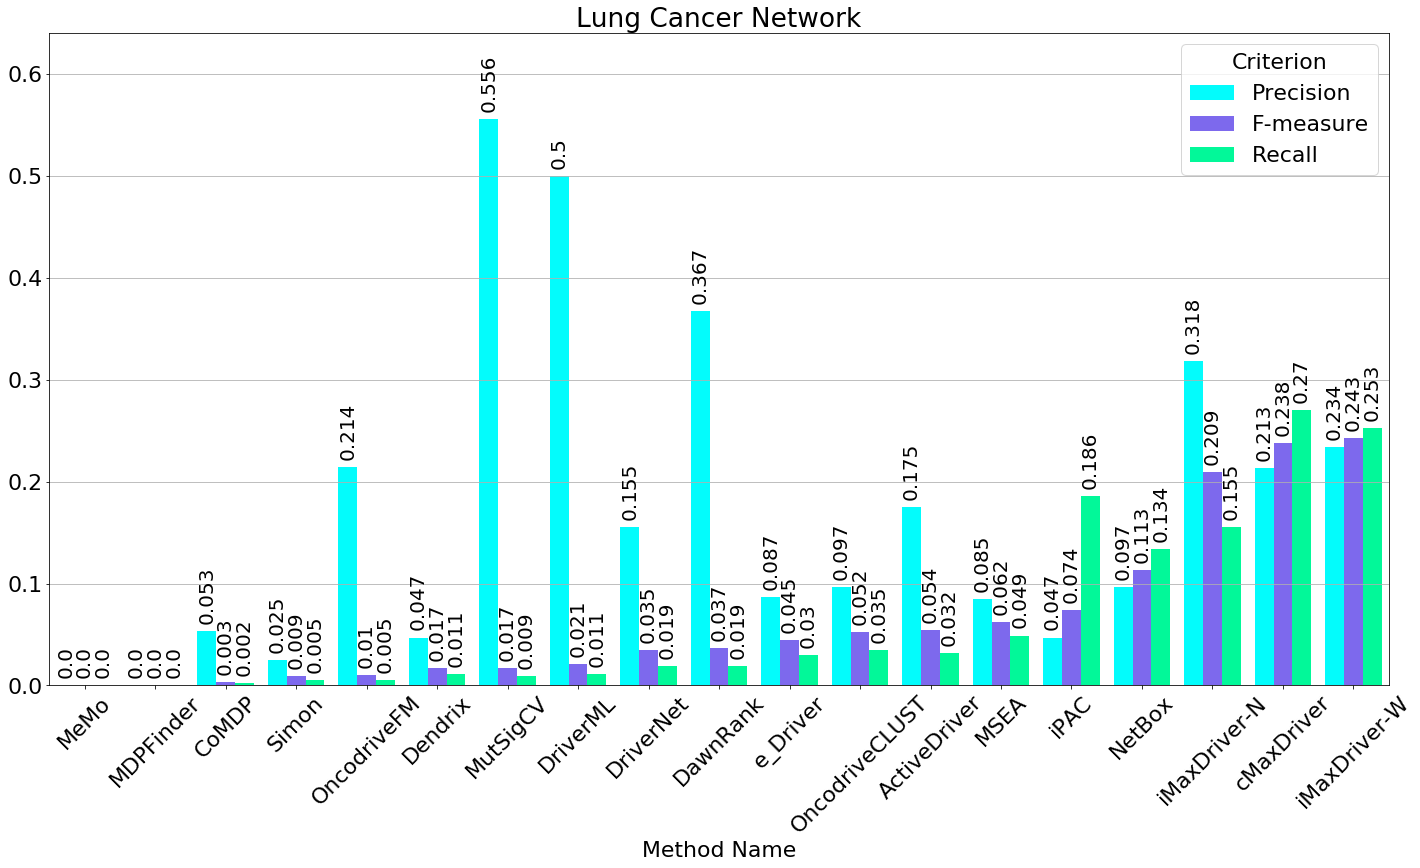

In [18]:
fig, ax = plt.subplots(figsize =(24, 12))
plt.grid(True)

sns.set_palette(sns.color_palette(colors))
C3 = sns.barplot(x="Method Name", y="value", data=criterion_L.iloc[:57,], hue="Criterion",
                 saturation=0.98, order=pd.DataFrame(criterion_L.iloc[19:38,]).sort_values("value")["Method Name"])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width(), 0.007+rect.get_height(),rect.get_height(), ha='right', 
             va='bottom', rotation=90, fontsize=20)
C3.set(ylabel=None) 
C3.set(ylim=(0, 1.1))
plt.setp(C3.get_xticklabels(), rotation=45)
plt.rcParams.update({'font.size': 22})
plt.legend(loc='upper right', title= 'Criterion')
plt.title('Lung Cancer Network')
C3.set(ylim=(0, 0.64))

plt.savefig('L.png', Cbox_inches='tight')
plt.show()

In [19]:
other_driversB = set.union(set(resultE_B[8].iloc[:,15]), set(resultE_B[8].iloc[:,14]), set(resultE_B[8].iloc[:,1]),
                           set(resultE_B[8].iloc[:,13]), set(resultE_B[8].iloc[:,12]), set(resultE_B[8].iloc[:,11]),
                           set(resultE_B[8].iloc[:,10]), set(resultE_B[8].iloc[:,9]), set(resultE_B[8].iloc[:,8]),
                           set(resultE_B[8].iloc[:,7]), set(resultE_B[8].iloc[:,6]) ,set(resultE_B[8].iloc[:,5]), 
                           set(resultE_B[8].iloc[:,4]), set(resultE_B[8].iloc[:,3]), set(resultE_B[8].iloc[:,2]),
                           set(resultE_B[8].iloc[:,0]))
len(other_driversB)

282

In [20]:
other_driversC = set.union(set(resultE_C[8].iloc[:,15]), set(resultE_C[8].iloc[:,14]), set(resultE_C[8].iloc[:,1]),
                           set(resultE_C[8].iloc[:,13]), set(resultE_C[8].iloc[:,12]), set(resultE_C[8].iloc[:,11]),
                           set(resultE_C[8].iloc[:,10]), set(resultE_C[8].iloc[:,9]), set(resultE_C[8].iloc[:,8]),
                           set(resultE_C[8].iloc[:,7]), set(resultE_C[8].iloc[:,6]) ,set(resultE_C[8].iloc[:,5]), 
                           set(resultE_C[8].iloc[:,4]), set(resultE_C[8].iloc[:,3]), set(resultE_C[8].iloc[:,2]),
                           set(resultE_C[8].iloc[:,0]))
len(other_driversC)

311

In [21]:
other_driversL = set.union(set(resultE_L[8].iloc[:,15]), set(resultE_L[8].iloc[:,14]), set(resultE_L[8].iloc[:,1]),
                           set(resultE_L[8].iloc[:,13]), set(resultE_L[8].iloc[:,12]), set(resultE_L[8].iloc[:,11]),
                           set(resultE_L[8].iloc[:,10]), set(resultE_L[8].iloc[:,9]), set(resultE_L[8].iloc[:,8]),
                           set(resultE_L[8].iloc[:,7]), set(resultE_L[8].iloc[:,6]) ,set(resultE_L[8].iloc[:,5]), 
                           set(resultE_L[8].iloc[:,4]), set(resultE_L[8].iloc[:,3]), set(resultE_L[8].iloc[:,2]),
                           set(resultE_L[8].iloc[:,0]))
len(other_driversL)

158

In [22]:
driverB_iMaxDriverN = resultE_B[8].iloc[:,16].dropna().reset_index(drop=True)
driverB_iMaxDriverW = resultE_B[8].iloc[:,17].dropna().reset_index(drop=True)
driverB_cMaxDriver = resultE_B[8].iloc[:,18].dropna().reset_index(drop=True)

driverC_iMaxDriverN = resultE_C[8].iloc[:,16].dropna().reset_index(drop=True)
driverC_iMaxDriverW = resultE_C[8].iloc[:,17].dropna().reset_index(drop=True)
driverC_cMaxDriver = resultE_C[8].iloc[:,18].dropna().reset_index(drop=True)

driverL_iMaxDriverN = resultE_L[8].iloc[:,16].dropna().reset_index(drop=True)
driverL_iMaxDriverW = resultE_L[8].iloc[:,17].dropna().reset_index(drop=True)
driverL_cMaxDriver = resultE_L[8].iloc[:,18].dropna().reset_index(drop=True)

In [23]:
def unique_g1(w, n, c):
    a = set(c)&set(w)
    b = set(c)&set(n)
    m = set(c)-b
    n = pd.DataFrame(m-a)
    return(n)

In [24]:
unique_B1 = unique_g1(driverB_iMaxDriverW,driverB_iMaxDriverN,driverB_cMaxDriver).rename(columns={0:'unique_B'})
print(len(unique_B1))
unique_C1 = unique_g1(driverC_iMaxDriverW,driverC_iMaxDriverN,driverC_cMaxDriver).rename(columns={0:'unique_C'})
print(len(unique_C1))
unique_L1 = unique_g1(driverL_iMaxDriverW,driverL_iMaxDriverN,driverL_cMaxDriver).rename(columns={0:'unique_L'})
print(len(unique_L1))

41
35
24


In [25]:
def unique_g2(w, n, c, o):
    a = set(c)&set(w)
    b = set(c)&set(n)
    m = set(c)&set(o)
    n = set(c)-m
    l = n-b
    f = pd.DataFrame(l-a)
    return(f)

In [26]:
unique_B2 = unique_g2(driverB_iMaxDriverW,driverB_iMaxDriverN,driverB_cMaxDriver,other_driversB).rename(columns={0:'unique_BO'})
print(len(unique_B2))
unique_C2 = unique_g2(driverC_iMaxDriverW,driverC_iMaxDriverN,driverC_cMaxDriver,other_driversC).rename(columns={0:'unique_CO'})
print(len(unique_C2))
unique_L2 = unique_g2(driverL_iMaxDriverW,driverL_iMaxDriverN,driverL_cMaxDriver,other_driversL).rename(columns={0:'unique_LO'})
print(len(unique_L2))

24
15
18


# Save unique gene

In [27]:
#pd.concat([unique_B1, unique_C1, unique_L1], axis=1).to_csv('unique1.csv',index=False)
#pd.concat([unique_B2, unique_C2, unique_L2], axis=1).to_csv('unique2.csv',index=False)

C:\Users\ASUS\anaconda3\lib\site-packages\venn\_backwards_compatibility.py:16: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "`get_labels()` is retained for backwards compatibility; " +
C:\Users\ASUS\anaconda3\lib\site-packages\venn\_backwards_compatibility.py:32: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ASUS\anaconda3\lib\site-packages\venn\_backwards_compatibility.py:32: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Ma

<Figure size 648x648 with 0 Axes>

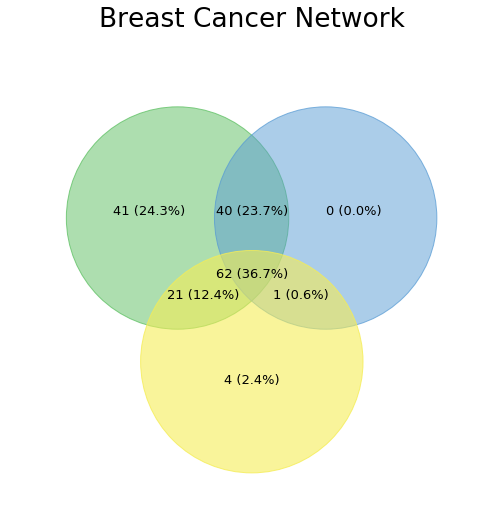

<Figure size 648x648 with 0 Axes>

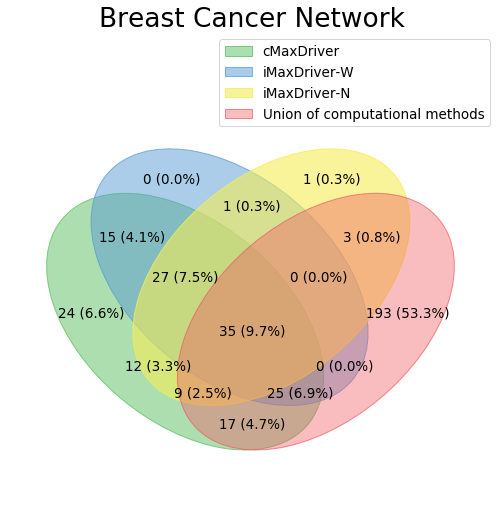

In [28]:
plt.figure(figsize=((9,9)))  
labels = venn.get_labels([set(driverB_cMaxDriver),
                          set(driverB_iMaxDriverW),
                          set(driverB_iMaxDriverN)],
                         fill=["percent", '\n',"number"])
fig, ax = venn.venn3(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N'],fontsize=13)
plt.title("Breast Cancer Network")
plt.legend([],[], frameon=False) 
plt.savefig('B-v2.png', Cbox_inches='tight')
fig.show()

plt.figure(figsize=(9,9))
labels = venn.get_labels([set(driverB_cMaxDriver),
                          set(driverB_iMaxDriverW),
                          set(driverB_iMaxDriverN),
                          set(other_driversB)],
                         fill=["percent","number"])
fig, ax = venn.venn4(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N','Union of computational methods'],fontsize=13.5)
plt.title("Breast Cancer Network")
plt.savefig('B-v1.png', Cbox_inches='tight')
fig.show()

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 648x648 with 0 Axes>

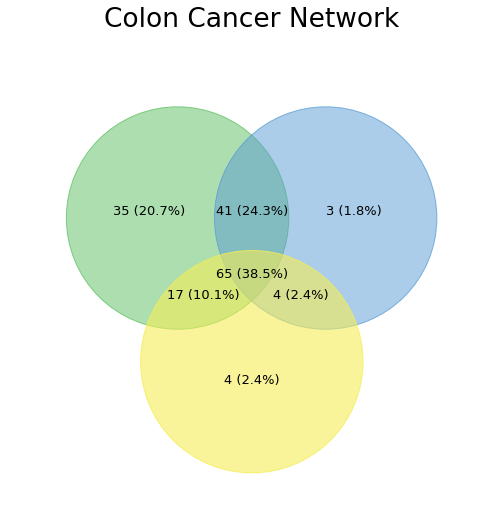

<Figure size 648x648 with 0 Axes>

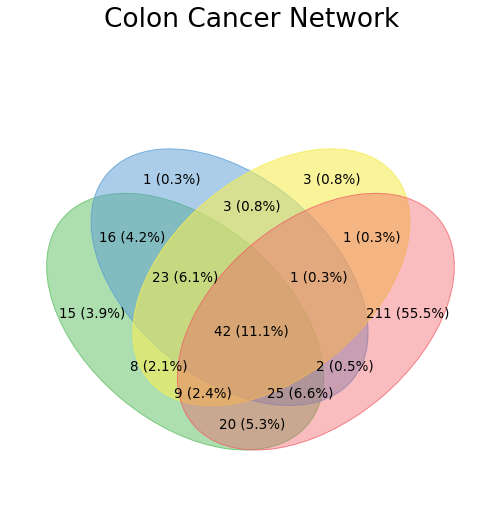

In [29]:
plt.figure(figsize=((9,9)))  
labels = venn.get_labels([set(driverC_cMaxDriver),
                          set(driverC_iMaxDriverW),
                          set(driverC_iMaxDriverN)],
                         fill=["percent", '\n',"number"])
fig, ax = venn.venn3(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N'], fontsize=13)
plt.title("Colon Cancer Network")
plt.legend([],[], frameon=False) 
plt.savefig('C-v1.png', Cbox_inches='tight')
fig.show()

plt.figure(figsize=((9,9))) 
labels = venn.get_labels([set(driverC_cMaxDriver),
                          set(driverC_iMaxDriverW),
                          set(driverC_iMaxDriverN),
                          set(other_driversC)],
                         fill=["percent","number"])
fig, ax = venn.venn4(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N','Union of computational methods'],fontsize=13.5)
plt.title("Colon Cancer Network")
plt.legend([],[], frameon=False) 
plt.savefig('C-v2.png', Cbox_inches='tight')
fig.show()

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 648x648 with 0 Axes>

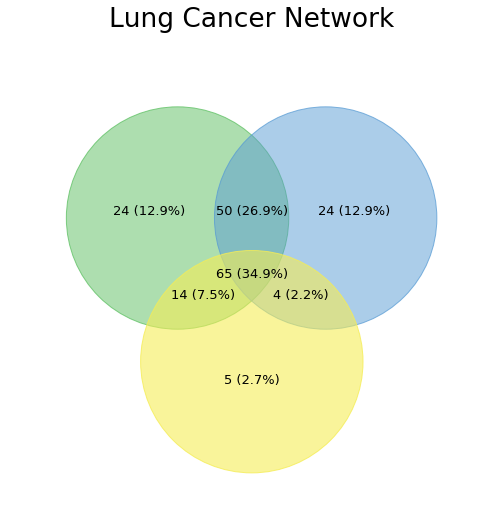

<Figure size 648x648 with 0 Axes>

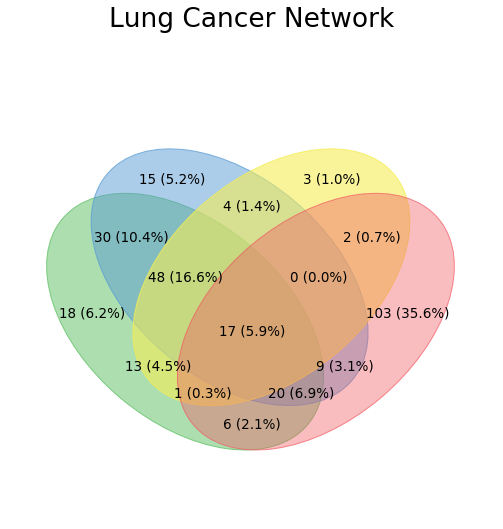

In [30]:
plt.figure(figsize=((9,9)))  
labels = venn.get_labels([set(driverL_cMaxDriver),
                          set(driverL_iMaxDriverW),
                          set(driverL_iMaxDriverN)],
                         fill=["percent", '\n',"number"])
fig, ax = venn.venn3(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N'], fontsize=13)
plt.title("Lung Cancer Network")
plt.legend([],[], frameon=False) 
plt.savefig('L-v1.png', Cbox_inches='tight')
fig.show()

plt.figure(figsize=((9,9)))  
labels = venn.get_labels([set(driverL_cMaxDriver),
                          set(driverL_iMaxDriverW),
                          set(driverL_iMaxDriverN),
                          set(other_driversL)],
                         fill=["percent","number"])
                        
fig, ax = venn.venn4(labels, names=['cMaxDriver','iMaxDriver-W','iMaxDriver-N','Union of computational methods'],fontsize=13.5)
plt.title("Lung Cancer Network")
plt.legend([],[], frameon=False) 
plt.savefig('L-v2.png', Cbox_inches='tight')
fig.show()